In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow import keras
import random

In [2]:
# plt settings

plt.style.use('default')


plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams["axes.grid"] = True

plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000

### Import marcap_data and preprocess

In [3]:
# import dataset - marcap_data
import os
os.chdir ('/Users/minseok/Documents/GitHub')

from marcap import marcap_data

In [4]:
#Panel Data : Year 2018
df = marcap_data(start = '2018-01-01',end = '2018-12-31')
len(df)

550675

In [5]:
df.head()

,Code,Name,Close,Changes,ChagesRatio,Volume,Amount,Open,High,Low,Marcap,MarcapRatio,Stocks,ForeignShares,ForeignRatio,Rank
Date,,,,,,,,,,,,,,,,
2018-01-02,005930,삼성전자,2551000.0,3000.0,0.1,169485.0,4.326774e+11,2569000.0,2570000.0,2539000.0,3.293303e+14,17.27,129098494.0,68095088.0,52.75,1.0
2018-01-02,000660,SK하이닉스,76600.0,100.0,0.1,2014838.0,1.546792e+11,77300.0,77300.0,76200.0,5.576498e+13,2.92,728002365.0,346184551.0,47.55,2.0
2018-01-02,005935,삼성전자우,2097000.0,7000.0,0.3,21940.0,4.553242e+10,2096000.0,2097000.0,2058000.0,3.827147e+13,2.01,18250580.0,15021675.0,82.31,3.0
2018-01-02,005380,현대차,149500.0,-6500.0,-4.2,731763.0,1.104238e+11,150500.0,153000.0,149000.0,3.293133e+13,1.73,220276479.0,99484123.0,45.16,4.0
2018-01-02,005490,POSCO,339000.0,6500.0,2.0,153013.0,5.161611e+10,335000.0,341000.0,332500.0,2.955634e+13,1.55,87186835.0,48888696.0,56.07,5.0


In [6]:
#Data preprocessing - drop irrelevant columns, reset index to hierarchical
df_1 = df.drop(['Name','Rank'],axis=1).reset_index().set_index(['Code','Date']).sort_index()

### Util Functions

In [8]:
def create_time_steps(length):
  return list(range(-length, 0))

### Class for data process, formatting, model initialization, training, prediction

In [18]:
class Module ():
    def __init__ (self, code, past, future):
        self.code = code
        self.df = df_1.loc[self.code, :].copy(deep = True)
        
        self.past = past #Look back 20 days
        self.future = future #Predict next 6 days
        
    def process (self):
        #adjust the prices
        latest_stocks = self.df.iloc[-1]['Stocks'] # 범위 마지막날 주식수(기준)
        chg_list = ['Close','Changes','Open','High','Low']
        for x in chg_list:
            self.df[x] = self.df[x] * (self.df['Stocks'] / latest_stocks) #Adjusted price
        self.df['Volume'] = self.df['Volume'] * (latest_stocks / self.df['Stocks'])
        self.df.drop(['Stocks','ForeignShares'],axis=1,inplace = True) #Delete misleading cols
        
    def format_data (self):
        #format the data for training
        self.valid_dates = self.df.index.unique()[self.past-1:-(self.future)]
        
        # 3/4 for training, 1/4 for validation
        test_len = int(len(self.valid_dates) * (3/4))
        print ("Train_no: {} and Test_no: {}".format(test_len,len(self.valid_dates)-test_len))
        
        #no. of features
        self.features_count = len(self.df.columns)
        
        #Train data
        self.train_data = np.empty((0,self.past,self.features_count), float)
        self.train_target = np.empty((0,self.future), float)
        for i in range (0, test_len):
            self.train_data = np.append(self.train_data, self.df[i:i+self.past].values.reshape(1,self.past,self.features_count), axis=0)
            self.train_target = np.append(self.train_target, self.df [i+self.past:i+(self.past + self.future)]['Close'].values.reshape(1,self.future), axis = 0)

        #Test data
        self.test_data = np.empty((0,self.past,self.features_count), float)
        self.test_target = np.empty((0,self.future), float)
        for i in range (test_len, len(self.valid_dates)):
            self.test_data = np.append(self.test_data, self.df[i:i+self.past].values.reshape(1,self.past,self.features_count), axis=0)
            self.test_target = np.append(self.test_target, self.df [i+self.past:i+(self.past + self.future)]['Close'].values.reshape(1,self.future), axis = 0)
            
    def lstm_model_init (self):
        #initialize and compile LSTM model
        self.model = keras.Sequential()

        self.model.add(keras.layers.LSTM(32, input_shape=(self.past,self.features_count), return_sequences=True))

        self.model.add(keras.layers.LSTM(16, activation = 'relu'))

        self.model.add(keras.layers.Dense(self.future))

        #complile the model
        self.model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
        
    def lstm_model_train (self, epoch):
        self.history = self.model.fit(self.train_data,self.train_target, epochs=epoch, verbose=1)
        plt.plot(self.history.history['loss'])
        
    def make_prediction (self, seed = None):
        if (seed is None):
            test_len = int(len(self.valid_dates) * (3/4))
            seed = random.randint(0, len(self.valid_dates)-test_len-1)
        print ('Seed : {}'.format(seed))
        
        pred_data = self.test_data[seed].reshape(1,self.past,self.features_count)
        pred_result = self.model.predict(pred_data)
        actual_result = self.test_target[seed]
        
        plt.figure(figsize=(12, 6))    
        num_in = create_time_steps(self.past)
        num_out = self.future
        
        plt.plot(num_in, np.array(pred_data.reshape(self.past,self.features_count)[:,0]), label='History')
        plt.plot(np.arange(num_out), np.array(actual_result).reshape(self.future), 'bo',
               label='True Future')
        plt.plot(np.arange(num_out), np.array(pred_result).reshape(self.future), 'ro',
                 label='Predicted Future')

        plt.legend(loc='upper left')
        plt.show()

### Create Module Object for Samsung Electronics (005930)

In [20]:
samsung = Module (code = '005930', past = 20, future = 6)

In [21]:
samsung.process()

In [22]:
samsung.format_data()

Train_no: 162 and Test_no: 54


In [23]:
print (samsung.train_data.shape)
print (samsung.train_target.shape)

(162, 20, 11)
(162, 6)


In [24]:
samsung.lstm_model_init()

Epoch 1/200
162/162 [==============================] - 4s 27ms/step - loss: 51546.6018
Epoch 2/200
162/162 [==============================] - 1s 3ms/step - loss: 51544.4157
Epoch 3/200
162/162 [==============================] - 1s 4ms/step - loss: 51535.9417
Epoch 4/200
162/162 [==============================] - 1s 4ms/step - loss: 51509.3061
Epoch 5/200
162/162 [==============================] - 1s 4ms/step - loss: 51416.0237
Epoch 6/200
162/162 [==============================] - 1s 3ms/step - loss: 50850.9032
Epoch 7/200
162/162 [==============================] - 1s 3ms/step - loss: 49286.3676
Epoch 8/200
162/162 [==============================] - 1s 4ms/step - loss: 45994.3791
Epoch 9/200
162/162 [==============================] - 1s 4ms/step - loss: 37904.4544
Epoch 10/200
162/162 [==============================] - 1s 4ms/step - loss: 26286.1006
Epoch 11/200
162/162 [==============================] - 1s 4ms/step - loss: 24368.3498
Epoch 12/200
162/162 [=============================

162/162 [==============================] - 1s 3ms/step - loss: 3745.7720
Epoch 97/200
162/162 [==============================] - 1s 3ms/step - loss: 3378.9780
Epoch 98/200
162/162 [==============================] - 1s 4ms/step - loss: 3573.2940
Epoch 99/200
162/162 [==============================] - 1s 5ms/step - loss: 3549.1211
Epoch 100/200
162/162 [==============================] - 1s 4ms/step - loss: 3521.8243
Epoch 101/200
162/162 [==============================] - 1s 3ms/step - loss: 3494.2036
Epoch 102/200
162/162 [==============================] - 1s 4ms/step - loss: 3764.6170
Epoch 103/200
162/162 [==============================] - 1s 4ms/step - loss: 3756.1425
Epoch 104/200
162/162 [==============================] - 0s 3ms/step - loss: 3318.1344
Epoch 105/200
162/162 [==============================] - 0s 3ms/step - loss: 3767.8934
Epoch 106/200
162/162 [==============================] - 0s 3ms/step - loss: 3659.5497
Epoch 107/200
162/162 [==============================] - 0s 

162/162 [==============================] - 1s 4ms/step - loss: 3229.3452
Epoch 191/200
162/162 [==============================] - 1s 3ms/step - loss: 3583.6323
Epoch 192/200
162/162 [==============================] - 1s 3ms/step - loss: 3308.1847
Epoch 193/200
162/162 [==============================] - 1s 4ms/step - loss: 3765.8559
Epoch 194/200
162/162 [==============================] - 1s 4ms/step - loss: 3952.3322
Epoch 195/200
162/162 [==============================] - 0s 3ms/step - loss: 3532.2309
Epoch 196/200
162/162 [==============================] - 0s 3ms/step - loss: 3604.5070
Epoch 197/200
162/162 [==============================] - 1s 4ms/step - loss: 3537.3844
Epoch 198/200
162/162 [==============================] - 1s 7ms/step - loss: 3593.6542
Epoch 199/200
162/162 [==============================] - 1s 6ms/step - loss: 3547.5793
Epoch 200/200
162/162 [==============================] - 1s 5ms/step - loss: 3718.8019


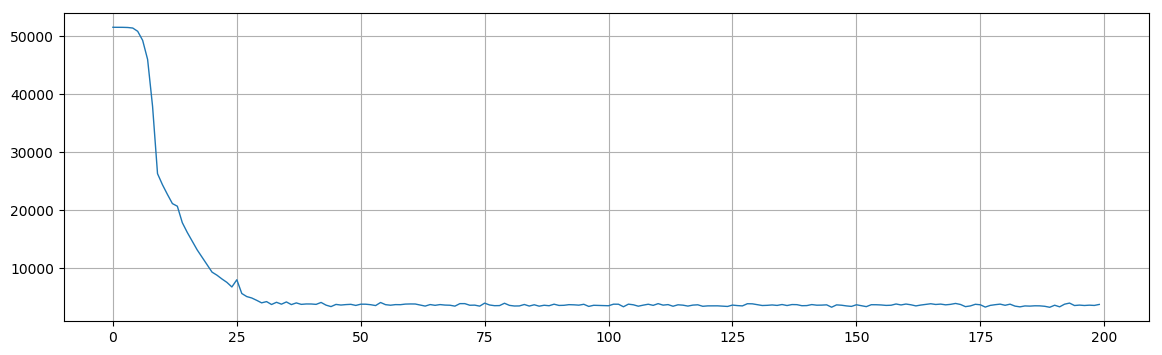

In [25]:
samsung.lstm_model_train(epoch = 200)

Seed : 40


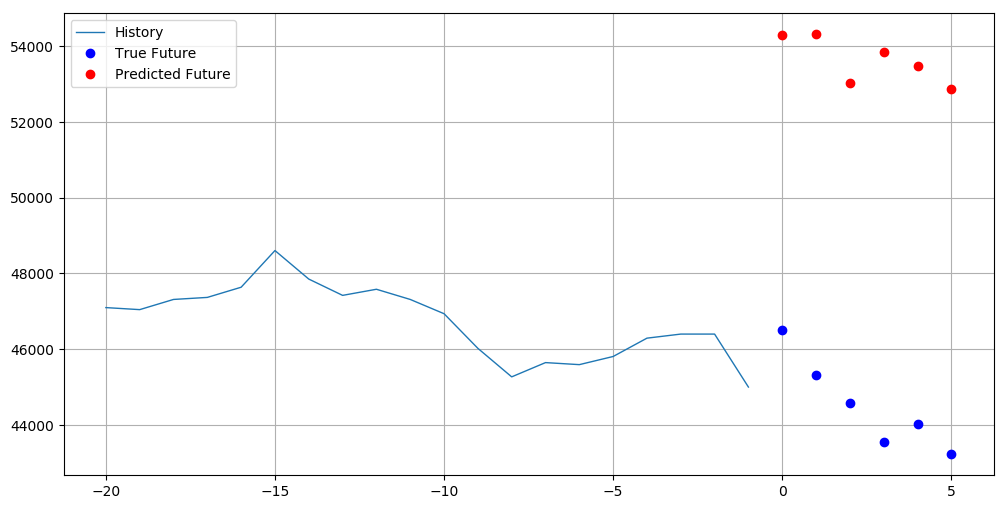

In [37]:
samsung.make_prediction(40)